In [1]:
include("pympc.jl")

Test Summary:    | Pass  Total
test sensitivity |  267    267


PyMPC

In [2]:
using Plots
pyplot()

/Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Plots.PyPlotBackend()

In [49]:
using AxisArrays
using JuMP, Gurobi
using ProgressMeter
using MLDataPattern
using JLD
import Nets
using DrakeVisualizer, GeometryTypes, CoordinateTransformations
DrakeVisualizer.any_open_windows() || DrakeVisualizer.new_window()

Process(`/Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/DrakeVisualizer/src/../deps/usr/bin/drake-visualizer`, ProcessRunning)

In [4]:
const states = Axis{:state}([
:q_com_x
:q_com_y
:q_r_x
:q_r_y
:q_l_x
:q_l_y
:qd_com_x
:qd_com_y
:qd_r_x
:qd_r_y
:qd_l_x
:qd_l_y
])

const inputs = Axis{:input}([
    :qdd_r_x,
    :qdd_r_y,
    :qdd_l_x,
    :qdd_l_y,
    :q_cop_x,
    :q_cop_y
        ])

const statesinputs = Axis{:statesinputs}(vcat(states.val, inputs.val))

AxisArrays.Axis{:statesinputs,Array{Symbol,1}}(Symbol[:q_com_x, :q_com_y, :q_r_x, :q_r_y, :q_l_x, :q_l_y, :qd_com_x, :qd_com_y, :qd_r_x, :qd_r_y, :qd_l_x, :qd_l_y, :qdd_r_x, :qdd_r_y, :qdd_l_x, :qdd_l_y, :q_cop_x, :q_cop_y])

In [5]:
g = 9.8
h = 1.0
ω = √(g / h)
Δt = 0.1

A = AxisArray(zeros(length(states), length(states)), 
    Axis{:state_out}(states.val), Axis{:state_in}(states.val))
B = AxisArray(zeros(length(states), length(inputs)),
    states, inputs)

for (q, qd) in [(:q_com_x, :qd_com_x), (:q_com_y, :qd_com_y), 
    (:q_r_x, :qd_r_x), (:q_r_y, :qd_r_y), (:q_l_x, :qd_l_x),
    (:q_l_y, :qd_l_y)]
    A[q, qd] = 1
end

A[:qd_com_x, :q_com_x] = ω^2
A[:qd_com_y, :q_com_y] = ω^2

B[:qd_com_x, :q_cop_x] = -ω^2
B[:qd_com_y, :q_cop_y] = -ω^2

B[:qd_r_x, :qdd_r_x] = 1.0
B[:qd_r_y, :qdd_r_y] = 1.0
B[:qd_l_x, :qdd_l_x] = 1.0
B[:qd_l_y, :qdd_l_y] = 1.0 



1.0

In [6]:
mat(x::AbstractArray) = convert(Matrix, reshape(x, length(x), 1))

mat (generic function with 1 method)

In [7]:
# state constraint regions

# bounds
x_min = AxisArray(fill(-Inf, length(states)), states)
x_min[:q_com_x] = -10
x_min[:q_com_y] = -10
x_min[:q_r_x] = -10
x_min[:q_r_y] = -10
x_min[:q_l_x] = -10
x_min[:q_l_y] = -10
x_min[:qd_com_x] = -10
x_min[:qd_com_y] = -10
x_min[:qd_r_x] = -10
x_min[:qd_r_y] = -10
x_min[:qd_l_x] = -10
x_min[:qd_l_y] = -10
x_max = -x_min
X_bounds = PyMPC.geometry.Polytope[:from_bounds](mat(x_min), mat(x_max))[:assemble]()

max_foot_accel = 30

u_min = AxisArray(fill(-Inf, length(inputs)), inputs)
u_min[:qdd_r_x] = -max_foot_accel
u_min[:qdd_r_y] = -max_foot_accel
u_min[:qdd_l_x] = -max_foot_accel
u_min[:qdd_l_y] = -max_foot_accel
u_max = -u_min
U_bounds = PyMPC.geometry.Polytope[:from_bounds](mat(u_min), mat(u_max))[:assemble]()

A_bounds = vcat(hcat(X_bounds[:A], zeros(2 * length(states), length(inputs))),
                hcat(zeros(2 * length(inputs), length(states)), U_bounds[:A]))
b_bounds = vcat(vec(X_bounds[:b]), vec(U_bounds[:b]))

outward_step = 0.3
inward_step = 0.1
forward_step = 0.4
backward_step = 0.4

# common state constraints
# -0.3 <= (r - c) <= -0.1
# -backward <= r - c <= forward
# 0.1 <= l - c <= 0.3
A_c = AxisArray(zeros(8, length(statesinputs)), 1:8, statesinputs)
b_c = AxisArray(zeros(8), 1:8)

A_c[1, :q_r_x] = 1
A_c[1, :q_com_x] = -1
b_c[1] = forward_step

A_c[2, :q_r_x] = -1
A_c[2, :q_com_x] = 1
b_c[2] = backward_step

A_c[3, :q_l_x] = 1
A_c[3, :q_com_x] = -1
b_c[3] = forward_step

A_c[4, :q_l_x] = -1
A_c[4, :q_com_x] = 1
b_c[4] = backward_step

A_c[5, :q_r_y] = 1
A_c[5, :q_com_y] = -1
b_c[5] = -inward_step

A_c[6, :q_r_y] = -1
A_c[6, :q_com_y] = 1
b_c[6] = outward_step

A_c[7, :q_l_y] = 1
A_c[7, :q_com_y] = -1
b_c[7] = outward_step

A_c[8, :q_l_y] = -1
A_c[8, :q_com_y] = 1
b_c[8] = -inward_step

-0.1

In [8]:
foot_size = 0.05
contact_vel_slack = 0.01

# right foot support
nc = 12
A_r = AxisArray(zeros(nc, length(statesinputs)), 1:nc, statesinputs)
b_r = AxisArray(zeros(nc), 1:nc)
A_r[1, :qd_r_x] = 1;  b_r[1] = contact_vel_slack
A_r[2, :qd_r_x] = -1; b_r[2] = contact_vel_slack
A_r[3, :qd_r_y] = 1;  b_r[3] = contact_vel_slack
A_r[4, :qd_r_y] = -1; b_r[4] = contact_vel_slack
A_r[5, :q_cop_x] = 1;  A_r[5, :q_r_x] = -1; b_r[5] = foot_size
A_r[6, :q_cop_x] = -1; A_r[6, :q_r_x] = 1;  b_r[6] = foot_size
A_r[7, :q_cop_y] = 1;  A_r[7, :q_r_y] = -1; b_r[7] = foot_size
A_r[8, :q_cop_y] = -1; A_r[8, :q_r_y] = 1;  b_r[8] = foot_size
A_r[9,  :qdd_r_x] = 1;  b_r[9] =  contact_vel_slack
A_r[10, :qdd_r_x] = -1; b_r[10] = contact_vel_slack
A_r[11, :qdd_r_y] = 1;  b_r[11] = contact_vel_slack
A_r[12, :qdd_r_y] = -1; b_r[12] = contact_vel_slack

# left foot support
A_l = AxisArray(zeros(nc, length(statesinputs)), 1:nc, statesinputs)
b_l = AxisArray(zeros(nc), 1:nc)
A_l[1, :qd_l_x] = 1;  b_l[1] = contact_vel_slack
A_l[2, :qd_l_x] = -1; b_l[2] = contact_vel_slack
A_l[3, :qd_l_y] = 1;  b_l[3] = contact_vel_slack
A_l[4, :qd_l_y] = -1; b_l[4] = contact_vel_slack
A_l[5, :q_cop_x] = 1;  A_l[5, :q_l_x] = -1; b_l[5] = foot_size
A_l[6, :q_cop_x] = -1; A_l[6, :q_l_x] = 1;  b_l[6] = foot_size
A_l[7, :q_cop_y] = 1;  A_l[7, :q_l_y] = -1; b_l[7] = foot_size
A_l[8, :q_cop_y] = -1; A_l[8, :q_l_y] = 1;  b_l[8] = foot_size
A_l[9,  :qdd_l_x] = 1;  b_l[9] =  contact_vel_slack
A_l[10, :qdd_l_x] = -1; b_l[10] = contact_vel_slack
A_l[11, :qdd_l_y] = 1;  b_l[11] = contact_vel_slack
A_l[12, :qdd_l_y] = -1; b_l[12] = contact_vel_slack

0.01

In [9]:
XU = [
    PyMPC.geometry.Polytope(vcat(A_bounds, A_c, A_r), mat(vcat(b_bounds, b_c, b_r)))[:assemble](),
    PyMPC.geometry.Polytope(vcat(A_bounds, A_c, A_l), mat(vcat(b_bounds, b_c, b_l)))[:assemble]()
]

2-element Array{PyCall.PyObject,1}:
 PyObject <pympc.geometry.Polytope instance at 0x13748b8c0>
 PyObject <pympc.geometry.Polytope instance at 0x13b258a28>

In [10]:
c = zeros(length(states), 1)

sys = PyMPC.dynamical_systems.DTPWASystem(
    [PyMPC.dynamical_systems.DTAffineSystem[:from_continuous](A, B, c, Δt),
     PyMPC.dynamical_systems.DTAffineSystem[:from_continuous](A, B, c, Δt)],
    XU)

PyObject <pympc.dynamical_systems.DTPWASystem object at 0x1302e9390>

In [11]:
N = 10
Q = AxisArray(0.001 * eye(length(states)), Axis{:states_1}(states.val), Axis{:states_2}(states.val))
Q[:qd_com_x, :qd_com_x] = 100
Q[:qd_com_y, :qd_com_y] = 100

R = AxisArray(0.001 * eye(length(inputs)), Axis{:inputs_1}(inputs.val), Axis{:inputs_2}(inputs.val))
R[:qdd_r_x, :qdd_r_x] = 0.1
R[:qdd_r_y, :qdd_r_y] = 0.1
R[:qdd_l_x, :qdd_l_x] = 0.1
R[:qdd_l_y, :qdd_l_y] = 0.1

P = Q

X_N = PyMPC.geometry.Polytope(vcat(X_bounds[:A], A_c[:, 1:length(states)]), mat(vcat(vec(X_bounds[:b]), b_c)))[:assemble]()

controller = PyMPC.control.MPCHybridController(
sys,
N,
"two",
Q,
R,
P,
X_N)

PyObject <pympc.control.MPCHybridController instance at 0x13b23cea8>

In [12]:
function run_mpc(controller, x0)
    u_feedforward, x_trajectory, cost, switching_sequence = controller[:feedforward](mat(x0))
    if isnan(u_feedforward[1][1])
        return u_feedforward[1], fill(NaN, length(u_feedforward[1]), length(x0)), x_trajectory
    end
    condensed = controller[:condense_program](switching_sequence)
    u, cost = condensed[:solve](mat(x0))
    active_set = condensed[:get_active_set](mat(x0), u)
    u_offset, u_linear = condensed[:get_u_sensitivity](active_set)
#     @show maximum(abs.(u_offset + u_linear * x0 - u))
#     @assert maximum(abs.(u_offset + u_linear * x0 - u)) <= 0.01
    u_feedforward[1], u_linear, x_trajectory
end

run_mpc (generic function with 1 method)

In [79]:
vis = Visualizer()[:pendulum]
delete!(vis)
setgeometry!(vis[:com], HyperSphere(Point(0., 0, 0), 0.1))
setgeometry!(vis[:cop], HyperSphere(Point(0., 0, 0), 0.02))

Visualizer with path prefix Symbol[:pendulum, :cop] using LCM LCMCore.LCM(Ptr{Void} @0x00007f880767ab00, "", RawFD(65), LCMCore.Subscription[LCMCore.Subscription{LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#9{DrakeVisualizer.CoreVisualizer}}}(LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#9{DrakeVisualizer.CoreVisualizer}}(DrakeVisualizer.Comms.CommsT, DrakeVisualizer.handle_msg), Ptr{Void} @0x00007f88068e2da0)])

In [14]:
function draw(vis, x_, u_)
    x = AxisArray(x_, states)
    u = AxisArray(u_, inputs)
    settransform!(vis[:com], Translation(x[:q_com_x], x[:q_com_y], h))
    settransform!(vis[:cop], Translation(u[:q_cop_x], u[:q_cop_y], 0))
    setgeometry!(vis[:feet][:r], PolyLine([Point(x[:q_r_x], x[:q_r_y], 0), Point(x[:q_com_x], x[:q_com_y], h)], 0.01, false, nothing, nothing))
    setgeometry!(vis[:feet][:l], PolyLine([Point(x[:q_l_x], x[:q_l_y], 0), Point(x[:q_com_x], x[:q_com_y], h)], 0.01, false, nothing, nothing))
end

draw (generic function with 1 method)

In [15]:
x0 = AxisArray(zeros(length(states)), states)
x0[:q_com_x] = 0
x0[:q_com_y] = 0
x0[:q_r_x] = 0
x0[:q_r_y] = -0.15
x0[:q_l_x] = 0
x0[:q_l_y] = 0.15
x0[:qd_com_x] = 0.4
x0[:qd_com_y] = 0.4
x0[:qd_r_x] = 0
x0[:qd_r_y] = 0
x0[:qd_l_x] = 0
x0[:qd_l_y] = 0

0

In [16]:
u_feedforward, x_trajectory, cost, switching_sequence = controller[:feedforward](mat(x0))

for (x, u) in zip(x_trajectory, u_feedforward)
    draw(vis, vec(x), vec(u))
    sleep(0.2)
end

In [17]:
function contact_state(x, u)
    q_r = [x[:q_r_x], x[:q_r_y]]
    q_l = [x[:q_l_x], x[:q_l_y]]
    q_cop = [u[:q_cop_x], u[:q_cop_y]]
    
    if norm(q_cop - q_r) < norm(q_cop - q_l)
        return :right
    else
        return :left
    end
end

function clip_cop!(x, u)
    q_r = [x[:q_r_x], x[:q_r_y]]
    q_l = [x[:q_l_x], x[:q_l_y]]
    q_cop = [u[:q_cop_x], u[:q_cop_y]]
    
    contact = contact_state(x,  u)
    if contact == :right
        q_target = q_r
    else
        q_target = q_l
    end

    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable m cop[1:2]
    @objective m Min sum((cop - q_cop).^2)
    @constraints m begin
        cop .- q_target .<= 0.04
        q_target .- cop .<= 0.04
    end
        
    solve(m)
    u[:q_cop_x] = getvalue(cop[1])
    u[:q_cop_y] = getvalue(cop[2])
end

clip_cop! (generic function with 1 method)

In [18]:
function update(x, u, Δt)
    u .= clamp.(u, u_min, u_max)
    contact = contact_state(x, u)
    clip_cop!(x, u)
    
    ẋ = AxisArray(A * x + B * u, states)
    
    if contact_state(x, u) == :right
        ẋ[:q_r_x] = 0
        ẋ[:q_r_y] = 0
    else
        ẋ[:q_l_x] = 0
        ẋ[:q_l_y] = 0
    end
    
    x .+= Δt .* ẋ
    
#     if contact_state(x, u) == :right
#         x[:qd_r_x] = 0
#         x[:qd_r_y] = 0
#     else
#         x[:qd_l_x] = 0
#         x[:qd_l_y] = 0
#     end
    
    x
end

update (generic function with 1 method)

In [19]:
function generate_x0()
    x0 = AxisArray(1.0 * randn(length(states)), states)
    x0[:q_com_x] = 0
    x0[:q_com_y] = 0
    x0[:q_r_x] = x0[:q_com_x] + (-backward_step + rand() * (forward_step - backward_step))
    x0[:q_r_y] = x0[:q_com_y] - (inward_step + rand() * (outward_step - inward_step))
    x0[:q_l_x] = x0[:q_com_x] + (-backward_step + rand() * (forward_step - backward_step))
    x0[:q_l_y] = x0[:q_com_y] + (inward_step + rand() * (outward_step - inward_step))
    if rand([true, false])
        x0[:qd_r_x] = 0
        x0[:qd_r_y] = 0
    else
        x0[:qd_l_x] = 0
        x0[:qd_l_y] = 0
    end
    x0
end

generate_x0 (generic function with 1 method)

In [20]:
@showprogress for i in 1:100
    x0 = generate_x0()
    u_feedforward, x_trajectory, cost, switching_sequence = controller[:feedforward](mat(x0))
    if !isnan(x_trajectory[1][1])
        for (x, u) in zip(x_trajectory, u_feedforward)
            draw(vis, vec(x), vec(u))
            sleep(0.1)
        end
        break
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [21]:
function simulate(x0, control, ts::StepRangeLen=0:0.01:5)
    x = copy(x0)
    for t in ts
        u = AxisArray(control(x), inputs)
        x = update(x, u, step(ts))
        draw(vis, x, u)
        sleep(step(ts))
    end
end

simulate (generic function with 2 methods)

In [134]:
x0 = generate_x0()
x = simulate(x0, x -> run_mpc(controller, x)[1][1:length(inputs)], 0:0.05:1)

LoadError: [91mInvalid coefficient NaN on variable cop[1][39m

num_samples = 1000
data = Vector{Tuple{Vector{Float64}, Matrix{Float64}}}()

@showprogress for i in 1:num_samples
    while true
        x0 = generate_x0()
        u, J, x_traj = run_mpc(controller, x0)
        if !isnan(u[1])
            push!(data, (x0, hcat(u, J[1:length(u), :])))
            for x in x_traj
                u, J, _ = run_mpc(controller, vec(x))
                if !isnan(u[1])
                    push!(data, (vec(x), hcat(u, J[1:length(u), :])))
                end
            end
            break
        end
    end
end

save("LIPM_1000_trajectory.jld", "data", data)

In [23]:
data = load("LIPM_1000_trajectory.jld")["data"]
train_data, test_data = splitobs(shuffleobs(data), 0.5)
train_data = train_data[1:20 * (length(train_data) ÷ 20)];

In [63]:
widths = [length(states), 32, 32, 32, 32, 32, 32, length(inputs)]
net = Nets.Net(widths)

q = ones(1, length(states) + 1)
q[2:end] = 1 / length(states)
loss = (params, x, y) -> sum(abs2, q .* (y - Nets.predict_sensitivity(net, params, x)))
loss_no_sensitivity = (params, x, y) -> sum(abs2, y[:, 1] - Nets.predict(net, params, x))

(::#79) (generic function with 1 method)

In [66]:
params = 2 * (rand(net) .- 0.5)
losses = Float64[]
nepoch = 50

@showprogress for i in 1:nepoch
    Nets.adam!(loss, params, train_data, Nets.AdamOpts(learning_rate=0.01 * 0.95^i, batch_size=40))
    push!(losses, mean(xy -> loss(params, xy[1], xy[2]), test_data))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:38



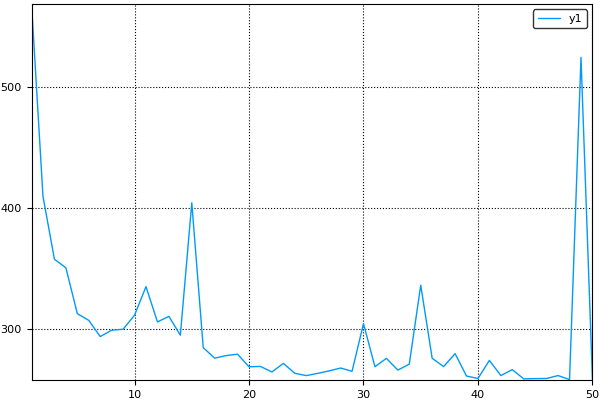

In [67]:
plot(losses)

In [113]:

x0 = generate_x0()
x0[:q_com_x] = 0
x0[:q_com_y] = 0
x0[:qd_com_x] = 0
x0[:qd_com_y] = 0
x = simulate(x0, x -> Nets.predict(net, params, x), 0:0.01:1)

In [63]:
Nets.predict(net, params, x0)

6-element Array{Float64,1}:
 37.5165  
  8.07977 
 12.0413  
  3.4672  
 -0.176957
  0.124447